# Customer Segmentation Using Clustering

imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from yellowbrick.cluster import KElbowVisualizer
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from scipy.stats import kstest, mannwhitneyu, kruskal, spearmanr
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.utils import resample
import warnings

warnings.filterwarnings('ignore')

reading datasets

In [2]:
customers = pd.read_csv('olist_customers_dataset.csv')
geolocation = pd.read_csv('olist_geolocation_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
order_payments = pd.read_csv('olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
category_name = pd.read_csv('product_category_name_translation.csv')

## Data Pre-processing & Exploratory Analysis

in customers dataset we have information about user's location.

In [3]:
customers

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS


from order_reviews we are interested in review score, since other columns have too many missing values.

In [4]:
order_reviews = order_reviews[['order_id', 'review_score']]

we merge order reviews, order payments and orders based on order id. also we merge order items and products based on product id and merge the final two datasets based on order id.

In [5]:
df_orders = pd.merge(pd.merge(order_reviews, order_payments, on='order_id', how='inner'), orders)
items_products = pd.merge(order_items, products, on='product_id', how='inner')
df_orders = pd.merge(df_orders, items_products, on='order_id', how='inner')

this process may have created duplicates so we drop duplicates.

In [6]:
df_orders.drop_duplicates(inplace=True)

now we are ready to aggregate the dataset based on customer id. for each column the choice is explained in the comment.

In [7]:
df_orders.columns

Index(['order_id', 'review_score', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'customer_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')

In [ ]:
customer_agg = df_orders.groupby('customer_id').agg({
    'order_id': 'count',                                    # Total number of orders, this shows how many orders a user had during this time
    'review_score': ['mean', 'std'],                        # mean review score for each user shows how satisfied they are with their orders on average, std to see how much scores vary
    'payment_sequential': 'mean',                           # how many sequences user create on it's payments on average?
    'payment_installments': 'mean',                         # payment installments on average
    'payment_value': ['sum', 'mean', 'min', 'max', 'std'],  # payment value on average, also we added min, max, sum and std to extract more information
    'order_status': lambda x: x.mode().iloc[0],             # mode of payment status for each user
    'payment_type': lambda x: x.mode().iloc[0],             # Most common payment method
    'order_purchase_timestamp': 'max',                      # Last purchase time
    'price': ['sum', 'mean'],                               # Total and average product price for each user
    'product_weight_g': ['mean', 'min', 'max', 'std'],      # Average, Min, Max and std for product weight
    'product_category_name': pd.Series.nunique,             # Number of unique product categories
    'freight_value': 'mean',                                # average fright value
    'product_name_lenght': 'mean',                          # average product name length
    'product_description_lenght': 'mean',                   # average description length
    'product_photos_qty': 'mean',                           # average number of photos
    'product_length_cm': 'mean',                            # average product length
    'product_height_cm': 'mean',                            # average product height        
    'product_width_cm':'mean'                               # average product width  
})

now we create extra columns for columns with more than one aggregation option.

In [9]:
customer_agg.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in customer_agg.columns]
customer_agg = customer_agg.reset_index()

In [10]:
customer_agg.columns

Index(['customer_id', 'order_id_count', 'review_score_mean',
       'review_score_std', 'payment_sequential_mean',
       'payment_installments_mean', 'payment_value_sum', 'payment_value_mean',
       'payment_value_min', 'payment_value_max', 'payment_value_std',
       'order_status_<lambda>', 'payment_type_<lambda>',
       'order_purchase_timestamp_max', 'price_sum', 'price_mean',
       'product_weight_g_mean', 'product_weight_g_min', 'product_weight_g_max',
       'product_weight_g_std', 'product_category_name_nunique',
       'freight_value_mean', 'product_name_lenght_mean',
       'product_description_lenght_mean', 'product_photos_qty_mean',
       'product_length_cm_mean', 'product_height_cm_mean',
       'product_width_cm_mean'],
      dtype='object')

std assumes more than one datapoint and returns NaN for this case, so we will fill these NaN values with 0.

In [11]:
customer_agg.review_score_std.fillna(0, inplace=True)
customer_agg.payment_value_std.fillna(0, inplace=True)
customer_agg.product_weight_g_std.fillna(0, inplace=True)

now we are ready to merge this dataset with customers dataset and drop ids.

In [12]:
df = pd.merge(customer_agg, customers, on='customer_id', how='inner')
df.drop(columns=['customer_id', 'customer_unique_id'], axis=0, inplace=True)

next we compare the distribution of numerical variables

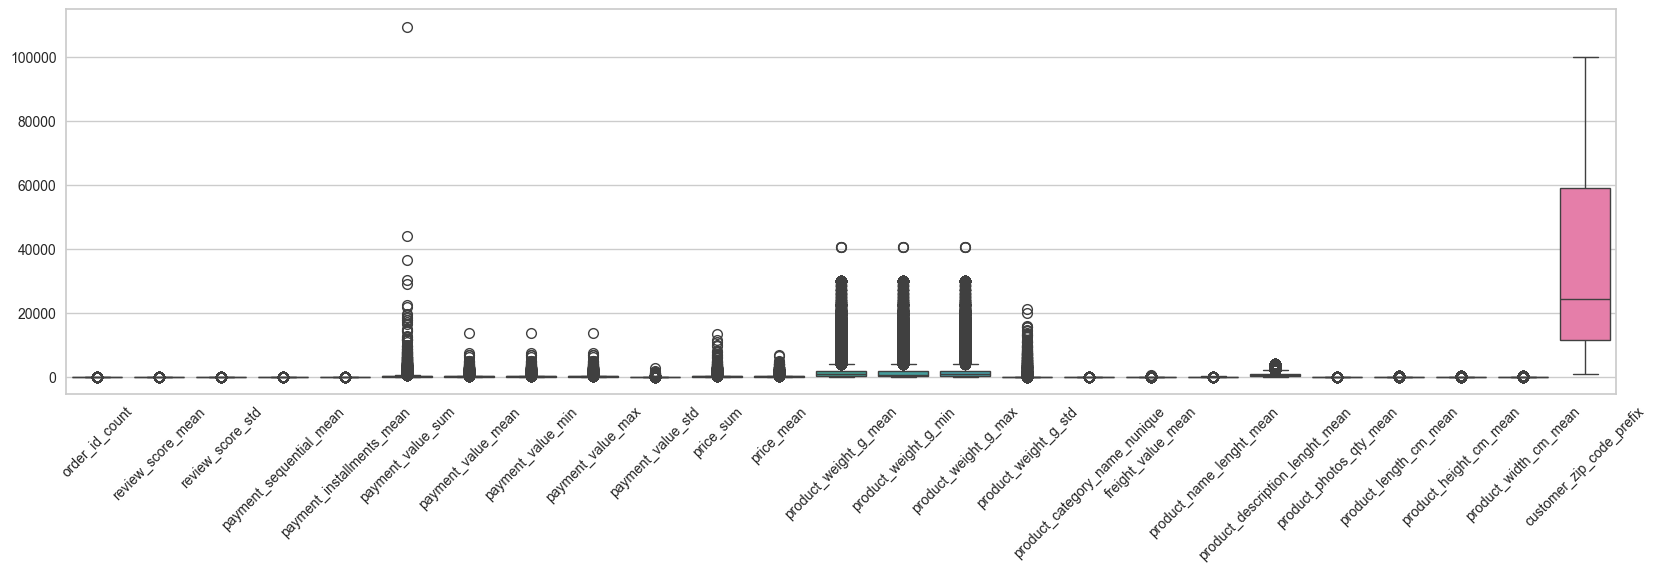

In [13]:
numerical_cols = [col for col in df.columns if df[col].dtype != 'O']
plt.figure(figsize=(20, 5))
sns.boxplot(df[numerical_cols])
plt.xticks(rotation=45)
None

we have outliers in payment_value_sum.

In [14]:
df['payment_value_sum'].describe()

count     97916.000000
mean        205.547790
std         606.064441
min           9.590000
25%          62.740000
50%         109.720000
75%         195.910000
max      109312.640000
Name: payment_value_sum, dtype: float64

this datapoint is too far away from others so we will delete it.

In [15]:
df[df.payment_value_sum>50000]

,order_id_count,review_score_mean,review_score_std,payment_sequential_mean,payment_installments_mean,payment_value_sum,payment_value_mean,payment_value_min,payment_value_max,payment_value_std,...,freight_value_mean,product_name_lenght_mean,product_description_lenght_mean,product_photos_qty_mean,product_length_cm_mean,product_height_cm_mean,product_width_cm_mean,customer_zip_code_prefix,customer_city,customer_state
8412,8,1.0,0.0,1.0,1.0,109312.64,13664.08,13664.08,13664.08,0.0,...,28.01,39.0,2493.0,3.0,16.0,16.0,16.0,20080,rio de janeiro,RJ


In [16]:
df.drop(df[df.payment_value_sum>50000].index, axis=0, inplace=True)

next we check heatmap for correlation between numerical features

<Axes: >

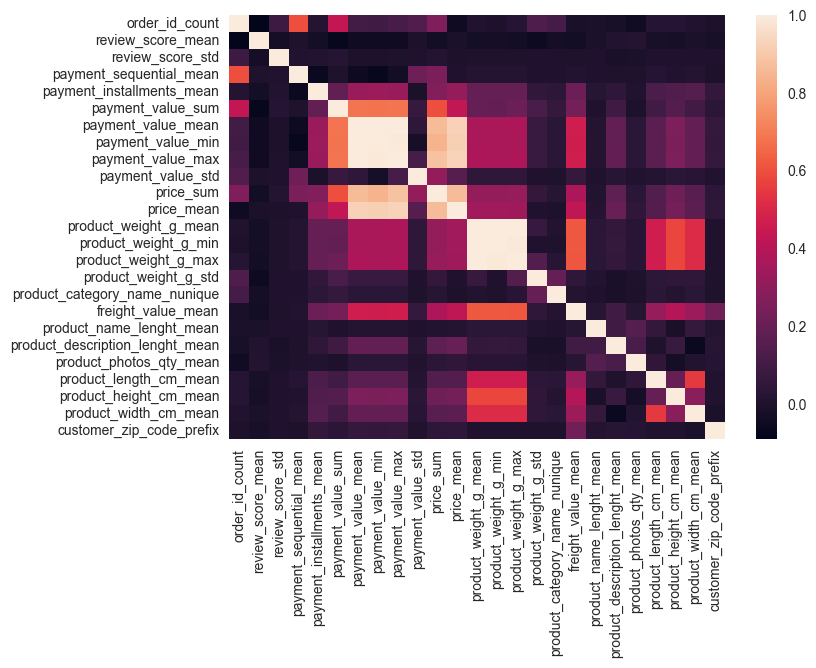

In [17]:
sns.heatmap(df[numerical_cols].corr())

this suggests that we should delete min and max features because they are highly correlated with mean.

In [18]:
df.drop(columns=['payment_value_min', 'payment_value_max', 'product_weight_g_min', 'product_weight_g_max'], axis=1, inplace=True)

since numerical columns have very different ranges we should consider scaling. next we check word cloud and pie plot for categorical columns.

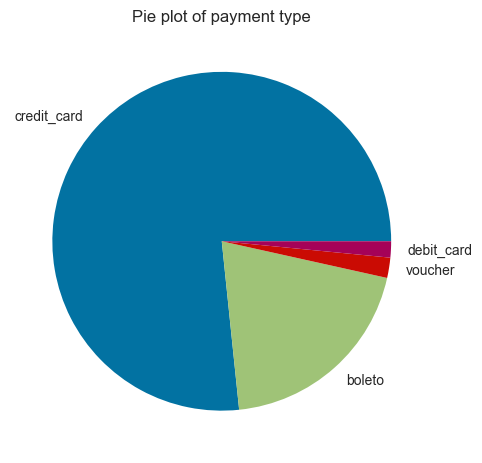

In [19]:
def pie(df, col):
    names = df.unique()
    values=[df[df==col].shape[0] for col in names]

    plt.pie(values, labels=names, labeldistance=1.1)
    plt.title(f'Pie plot of {col}')
    plt.show()

pie(df['payment_type_<lambda>'], 'payment type')

using credit card is the most common payment type

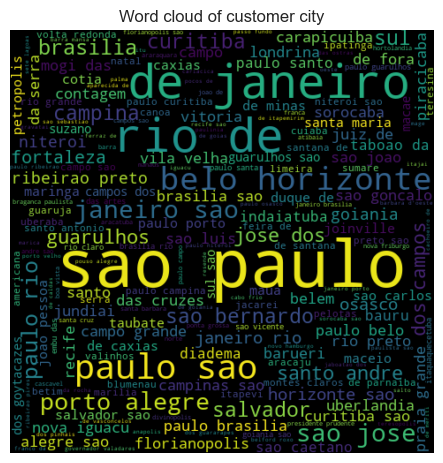

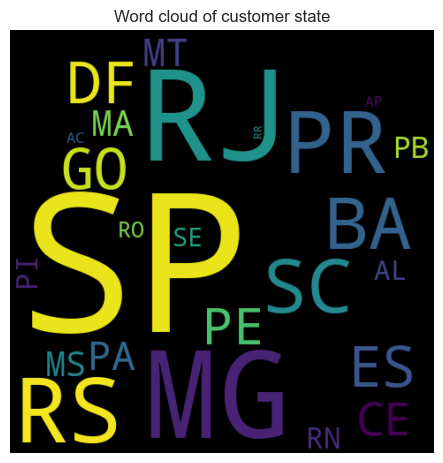

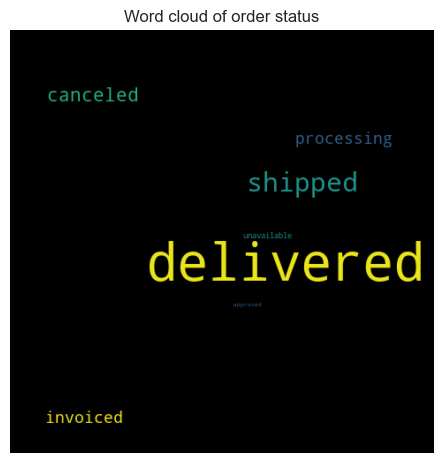

In [20]:
def word_cloud_plot(data, name):
    text = ' '.join(data)
    wordcloud = WordCloud(width=480, height=480, margin=0, random_state=0).generate(text)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.title(f'Word cloud of {name}')
    plt.show()

word_cloud_plot(df['customer_city'], 'customer city')
word_cloud_plot(df['customer_state'], 'customer state')
word_cloud_plot(df['order_status_<lambda>'], 'order status')

sao paulo is the most common city between customers, SP is the most common state and most of orders are delivered. next we try to answer a few questions about the dataset. 

    Does payment_value_sum follow a normal distribution?

In [21]:
kstest(df['payment_value_sum'], 'norm')

KstestResult(statistic=1.0, pvalue=0.0, statistic_location=9.59, statistic_sign=-1)

by using kstest we can see that the distribution of payment_value_sum is not normal.

<Axes: xlabel='payment_value_sum', ylabel='Density'>

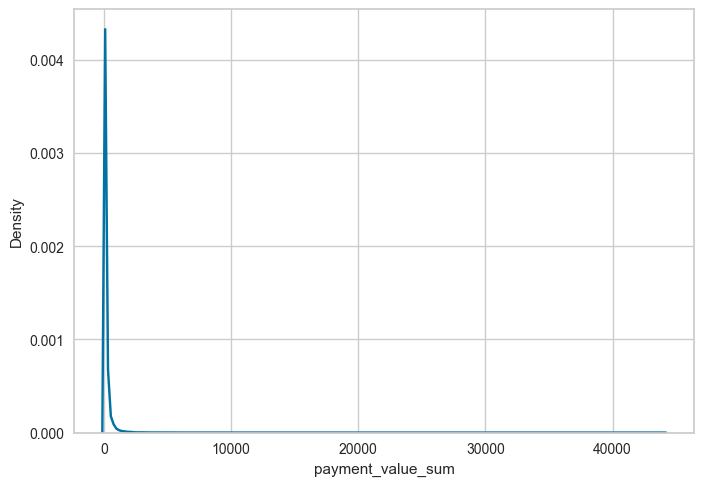

In [22]:
sns.kdeplot(df['payment_value_sum'])

to undrestand this distribution better, we apply log to it.

<Axes: xlabel='payment_value_sum', ylabel='Density'>

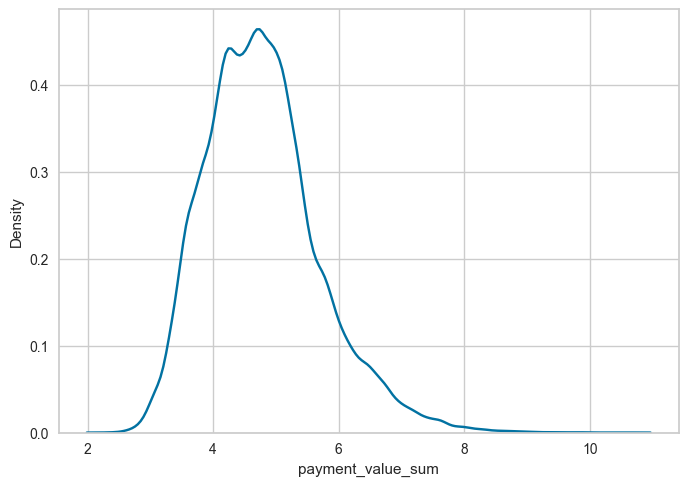

In [23]:
sns.kdeplot(np.log(df['payment_value_sum']))

    Do customers with higher review score mean, spend different from those with less review score?

we consider the threshold 4 for high and low review score

In [24]:
df['review_score_mean'].describe()

count    97915.000000
mean         4.105117
std          1.330254
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: review_score_mean, dtype: float64

and apply one sided Mannwhitney U test 

In [23]:
mannwhitneyu(df[df.review_score_mean>4]['payment_value_sum'], df[df.review_score_mean<=4]['payment_value_sum'], alternative='less')

MannwhitneyuResult(statistic=1109667174.5, pvalue=3.5921804923329904e-39)

this p-value confirms that the spending between these two groups are different and customers with higher review scores spend less.

    Does customer's state effect customer's spending? 

In [ ]:
kruskal(*[df[df.customer_state==state]['payment_value_sum'] for state in df['customer_state'].unique()])

KruskalResult(statistic=1694.8109444007355, pvalue=0.0)

yes it does.

    Do customers with sequential payments, spend higher on average?

In [27]:
mannwhitneyu(df[df.payment_sequential_mean>1]['payment_value_sum'], df[df.payment_sequential_mean<=1]['payment_value_sum'], alternative='greater')

MannwhitneyuResult(statistic=138179439.0, pvalue=0.990955866852171)

we can't conclude anything from this test, however with the confidence level of 0.05 we can say that customers with sequential payments spend less on average.

In [28]:
mannwhitneyu(df[df.payment_sequential_mean>1]['payment_value_sum'], df[df.payment_sequential_mean<=1]['payment_value_sum'], alternative='less')

MannwhitneyuResult(statistic=138179439.0, pvalue=0.009044149196230795)

    Is there a relationship between number of orders and payment value sum?

In [29]:
spearmanr(df['order_id_count'], df['payment_value_sum'])

SignificanceResult(statistic=0.3557580052308007, pvalue=0.0)

yes there is. we can see this relationship in the next plot.

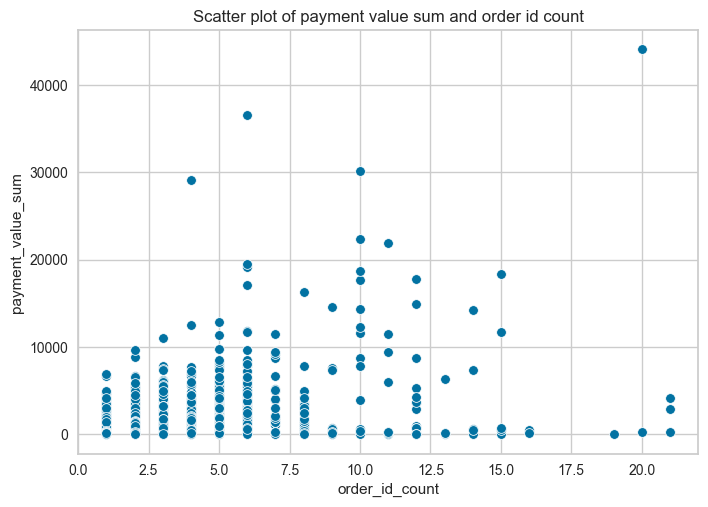

In [30]:
sns.scatterplot(x=df[df.order_id_count<22]['order_id_count'], y=df[df.order_id_count<22]['payment_value_sum'])
plt.title('Scatter plot of payment value sum and order id count')
None

next we want to replace missing values and encode categorical columns.

In [31]:
df.isna().sum()

order_id_count                        0
review_score_mean                     0
review_score_std                      0
payment_sequential_mean               0
payment_installments_mean             0
payment_value_sum                     0
payment_value_mean                    0
payment_value_std                     0
order_status_<lambda>                 0
payment_type_<lambda>                 0
order_purchase_timestamp_max          0
price_sum                             0
price_mean                            0
product_weight_g_mean                16
product_weight_g_std                  0
product_category_name_nunique         0
freight_value_mean                    0
product_name_lenght_mean           1379
product_description_lenght_mean    1379
product_photos_qty_mean            1379
product_length_cm_mean               16
product_height_cm_mean               16
product_width_cm_mean                16
customer_zip_code_prefix              0
customer_city                         0


to encode order_purchase_timestamp_max we count days from the last time the user ordered something to last timestamp in this column.

In [32]:
df['order_purchase_timestamp_max'] = pd.to_datetime(df['order_purchase_timestamp_max']) # first we fix dtype
df['order_purchase_timestamp_max'] = (df['order_purchase_timestamp_max'].max() - df['order_purchase_timestamp_max']).dt.days

to use other methods we split the dataset first. We will not use test set, but since some imputing or encoding methods cause data leakage and in some approches we may need to predict the performance of our model on unseen data, we split the dataset. however we keep 0.9 of datapoints in train set. this was also done because of computational problems.

In [33]:
df_train, df_test = train_test_split(df, random_state=42, train_size=0.9)

to encode order status and payment type, since these columns do not have so many categories we use one-hot encoding.

In [34]:
df_train = pd.get_dummies(df_train, columns=['order_status_<lambda>', 'payment_type_<lambda>'], dtype='int')
df_test = pd.get_dummies(df_test, columns=['order_status_<lambda>', 'payment_type_<lambda>'], dtype='int')

and for customer_city and customer_state we use frequency encoding with normalizing.

In [35]:
city_freq = df_train['customer_city'].value_counts(normalize=True)
df_train['customer_city'] = df_train['customer_city'].map(city_freq)
df_test['customer_city'] = df_test['customer_city'].map(city_freq)

state_freq = df_train['customer_state'].value_counts(normalize=True)
df_train['customer_state'] = df_train['customer_state'].map(state_freq)
df_test['customer_state'] = df_test['customer_state'].map(state_freq)

for missing values in product_name_lenght_mean, product_description_lenght_mean and product_photos_qty_mean, we use KNNImputer.

In [36]:
imputer = KNNImputer(n_neighbors=5)
df_train[['product_name_lenght_mean', 'product_description_lenght_mean', 'product_photos_qty_mean']] = imputer.fit_transform(df_train[['product_name_lenght_mean', 'product_description_lenght_mean', 'product_photos_qty_mean']])  # Works on full numeric subset
df_test[['product_name_lenght_mean', 'product_description_lenght_mean', 'product_photos_qty_mean']] = imputer.transform(df_test[['product_name_lenght_mean', 'product_description_lenght_mean', 'product_photos_qty_mean']])  # Works on full numeric subset

and for the rest of missing values we replace them mean of that column.

In [37]:
for col in ['product_weight_g_mean', 'product_length_cm_mean', 'product_height_cm_mean', 'product_width_cm_mean']:
    df_train[col] = df_train[col].fillna(df_train[col].mean())
    df_test[col] = df_test[col].fillna(df_train[col].mean())

now we don't have any missing values or non numerical columns.

In [38]:
df_train.isna().sum()

order_id_count                       0
review_score_mean                    0
review_score_std                     0
payment_sequential_mean              0
payment_installments_mean            0
payment_value_sum                    0
payment_value_mean                   0
payment_value_std                    0
order_purchase_timestamp_max         0
price_sum                            0
price_mean                           0
product_weight_g_mean                0
product_weight_g_std                 0
product_category_name_nunique        0
freight_value_mean                   0
product_name_lenght_mean             0
product_description_lenght_mean      0
product_photos_qty_mean              0
product_length_cm_mean               0
product_height_cm_mean               0
product_width_cm_mean                0
customer_zip_code_prefix             0
customer_city                        0
customer_state                       0
order_status_<lambda>_approved       0
order_status_<lambda>_can

since ranges of columns are different we scale them.

In [39]:
df_train.describe()

,order_id_count,review_score_mean,review_score_std,payment_sequential_mean,payment_installments_mean,payment_value_sum,payment_value_mean,payment_value_std,order_purchase_timestamp_max,price_sum,...,order_status_<lambda>_canceled,order_status_<lambda>_delivered,order_status_<lambda>_invoiced,order_status_<lambda>_processing,order_status_<lambda>_shipped,order_status_<lambda>_unavailable,payment_type_<lambda>_boleto,payment_type_<lambda>_credit_card,payment_type_<lambda>_debit_card,payment_type_<lambda>_voucher
count,88123.000000,88123.000000,88123.000000,88123.00000,88123.000000,88123.000000,88123.000000,88123.000000,88123.000000,88123.000000,...,88123.000000,88123.000000,88123.000000,88123.000000,88123.000000,88123.000000,88123.000000,88123.000000,88123.000000,88123.000000
mean,1.194058,4.106221,0.002743,1.02307,2.910933,205.096999,157.625110,1.469877,244.431976,143.975237,...,0.004596,0.978439,0.003291,0.003064,0.010531,0.000057,0.199380,0.765737,0.015546,0.019337
std,0.737872,1.329985,0.068791,0.18508,2.697884,509.363035,211.555702,20.287083,153.334211,234.787666,...,0.067637,0.145245,0.057272,0.055268,0.102078,0.007532,0.399537,0.423540,0.123713,0.137706
min,1.000000,1.000000,0.000000,1.00000,0.000000,9.590000,1.737500,0.000000,0.000000,0.850000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,4.000000,0.000000,1.00000,1.000000,62.710000,60.070000,0.000000,121.000000,47.400000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,1.000000,5.000000,0.000000,1.00000,2.000000,109.750000,103.190000,0.000000,225.000000,89.180000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,5.000000,0.000000,1.00000,4.000000,196.070000,175.080000,0.000000,354.000000,154.900000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,63.000000,5.000000,2.828427,11.50000,24.000000,44048.000000,7274.880000,2661.238797,728.000000,10856.100000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [40]:
scaler = StandardScaler()
df_transformed = scaler.fit_transform(df_train)

## Baseline Clustering and Model Variants & Dimensionality Reduction

first we write two functions for clustering evaluation.

In [42]:
def compute_wcss(X, labels):
    wcss = 0
    unique_labels = np.unique(labels)
    for label in unique_labels:
        cluster_points = X[labels == label]
        cluster_center = cluster_points.mean(axis=0)
        wcss += np.sum((cluster_points - cluster_center) ** 2)
    return wcss.sum()

def results(X, labels):
    print(f'WCSS: {compute_wcss(X, labels)}')
    print(f'Silhouette Score: {silhouette_score(X, labels, random_state=0)}')
    print(f'Davies Bouldin Score: {davies_bouldin_score(X, labels)}')

now we expriment with different clustering algorithms, starting with KMeans.

In [89]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_clusters = kmeans.fit_predict(df_transformed)
results(df_transformed, kmeans_clusters)

WCSS: 2783551.8211219283
Silhouette Score: 0.3738998403400169
Davies Bouldin Score: 2.1833519422614547


to improve these results, we try to find the besk k using elbow method.

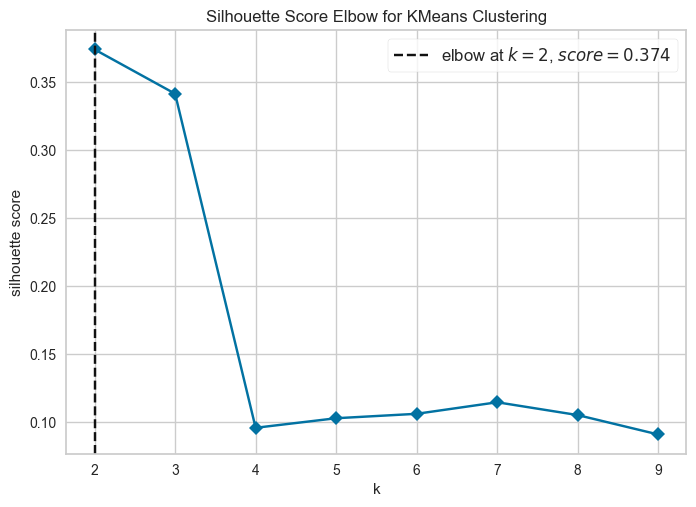

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [90]:
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2, 10), timings=False, metric='silhouette')

visualizer.fit(df_transformed)
visualizer.show()

two clusters give us the best Silhouette score between 2 to 9 clusters. next we check DBSCAN. this one is challenging since most of choices for eps and min points result in only one cluster.

In [97]:
dbscan = DBSCAN(eps=0.01, min_samples=5)
dbscan_clusters = dbscan.fit_predict(df_transformed)
results(df_transformed, dbscan_clusters)

WCSS: 2995962.228636629
Silhouette Score: -0.2771926179702712
Davies Bouldin Score: 1.3033184739868975


Agglomerative Clustering with single linkage and 5 clusters shows better results.

In [92]:
agg = AgglomerativeClustering(n_clusters=5, linkage='single')
agg_clusters = agg.fit_predict(df_transformed)
results(df_transformed, agg_clusters)

WCSS: 2790528.4541482027
Silhouette Score: 0.9325097683242839
Davies Bouldin Score: 0.05035957670595538


next we check dendrogram for agglomerative clustering

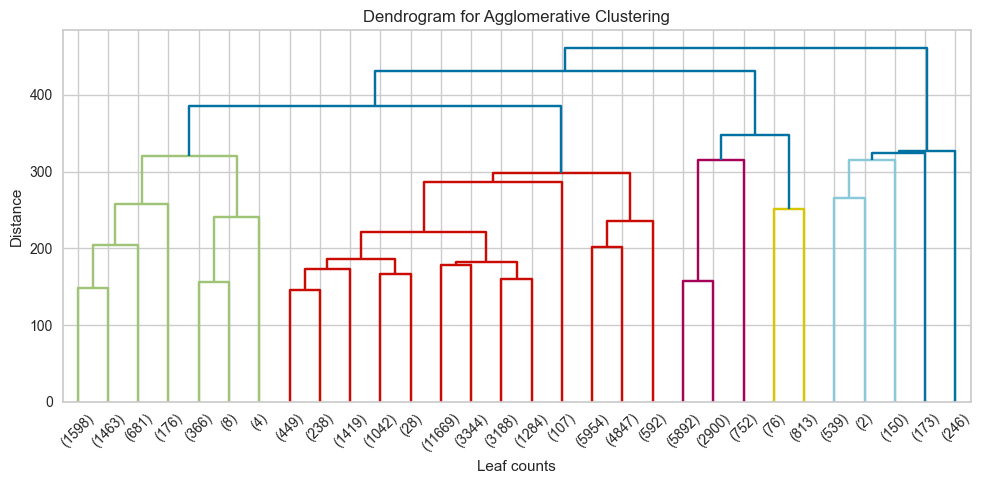

In [93]:
# we use only a random subset of 1000 points due to computentational problems
X_subset = resample(df_transformed, n_samples=50000, random_state=42)
linked = linkage(X_subset, method='ward')

# Step 2: Plot dendrogram
plt.figure(figsize=(10, 5))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           truncate_mode='lastp', p=30,
           show_leaf_counts=True)

plt.title("Dendrogram for Agglomerative Clustering")
plt.xlabel("Leaf counts")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

a cut between 300 and 400 will prevent from larger increase in distance and doesn't give us too many clusters.

now we plot clusters for each algorithm by applying PCA to df_transformed

In [48]:
def plot_with_pca(df, labels, model, cluster_centers=None, pca=True):
    if pca:
        pca = PCA(n_components=2) # PCA
        X_pca = pca.fit_transform(df)
    else:
        X_pca = df

    colors = [
    "#1f77b4",  # Muted Blue
    "#ff7f0e",  # Vivid Orange
    "#2ca02c",  # Fresh Green
    "#d62728",  # Bold Red
    "#9467bd",  # Soft Purple
    "#8c564b",  # Brown/Brick
    "#e377c2",  # Pink/Magenta
    "#17becf"   # Cyan/Teal
    
    ]

    plt.figure(figsize=(8, 6)) # plot

    n_clusters = len(np.unique(labels))

    if model=='DBSCAN':
        plt.scatter(X_pca[labels == -1, 0], X_pca[labels == -1, 1], s=50, c=colors[0], label='noise')

    for i in range(n_clusters):
        plt.scatter(X_pca[labels == i, 0], X_pca[labels == i, 1], s=50, c=colors[i+1], label=f'Cluster {i+1}')
        
    try:
        if cluster_centers.any() != None:
            if pca:
                cluster_centers = pca.transform(cluster_centers)
            plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=300, c='black', marker='X', label='Centers', edgecolor='w', linewidth=2)
    except AttributeError:
        pass

    plt.title(f'{model} clustering result for data projected onto PC1 and PC2')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

results for kmeans

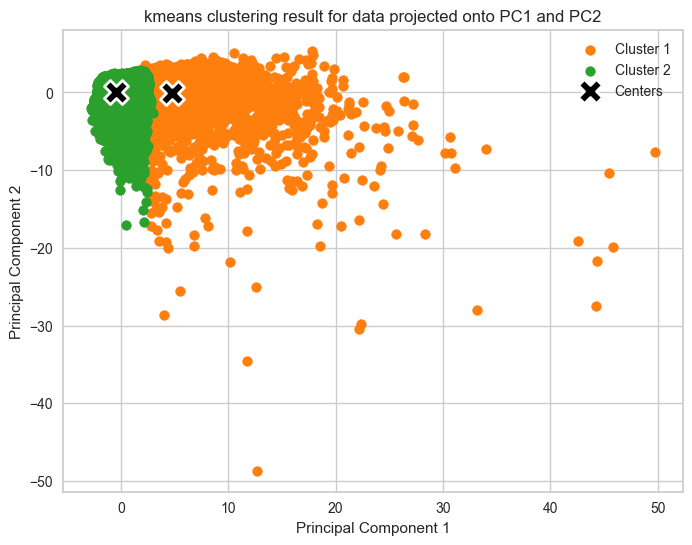

In [95]:
plot_with_pca(df_transformed, kmeans_clusters, 'kmeans', kmeans.cluster_centers_)

results for DBSCAN

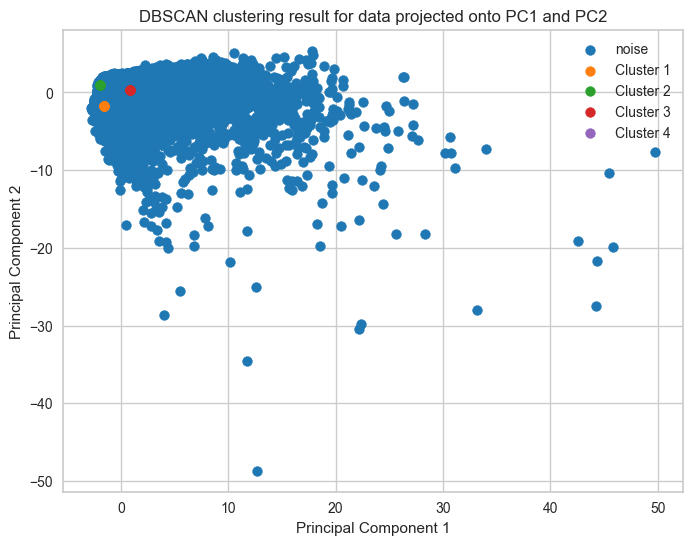

In [98]:
plot_with_pca(df_transformed, dbscan_clusters, 'DBSCAN')

results for AgglomerativeClustering

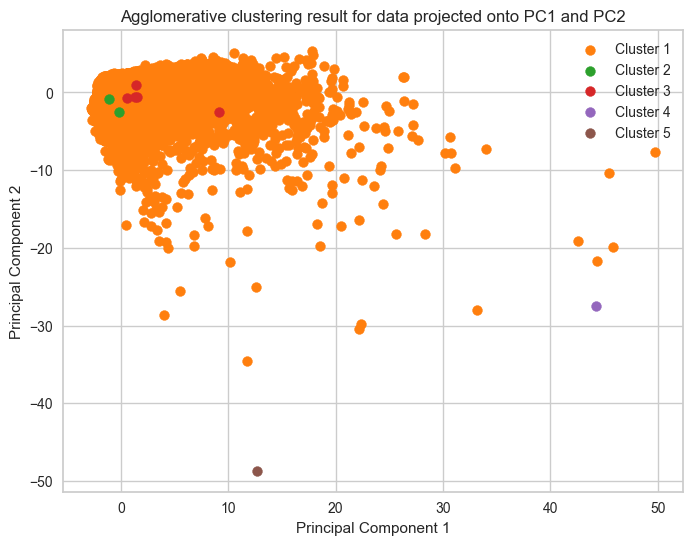

In [99]:
plot_with_pca(df_transformed, agg_clusters, 'Agglomerative')

now we apply pca to dataset and then test clustering algorithms on the new dataset

In [50]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_transformed)

for kmeans the results have improved

In [101]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_clusters = kmeans.fit_predict(df_pca)
results(df_pca, kmeans_clusters)

WCSS: 379130.7635103181
Silhouette Score: 0.6116252621581775
Davies Bouldin Score: 0.8508254012723995


the best choice for k is still 2.

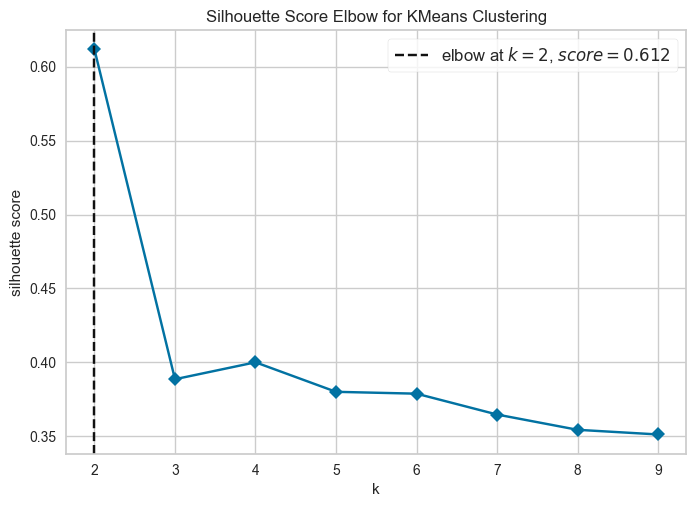

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [102]:
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2, 10), timings=False, metric='silhouette')

visualizer.fit(df_pca)
visualizer.show()

DBSCAN also shows better results.

In [103]:
dbscan = DBSCAN(eps=0.7, min_samples=30)
dbscan_clusters = dbscan.fit_predict(df_pca)
results(df_pca, dbscan_clusters)

WCSS: 474344.36572488124
Silhouette Score: 0.8078317521225792
Davies Bouldin Score: 0.7588276922978282


for agglomerative clustering results are almost the same

In [104]:
agg = AgglomerativeClustering(n_clusters=5, linkage='single')
agg_clusters = agg.fit_predict(df_pca)
results(df_pca, agg_clusters)

WCSS: 566628.2499130153
Silhouette Score: 0.9257928760746955
Davies Bouldin Score: 0.26860658778836977


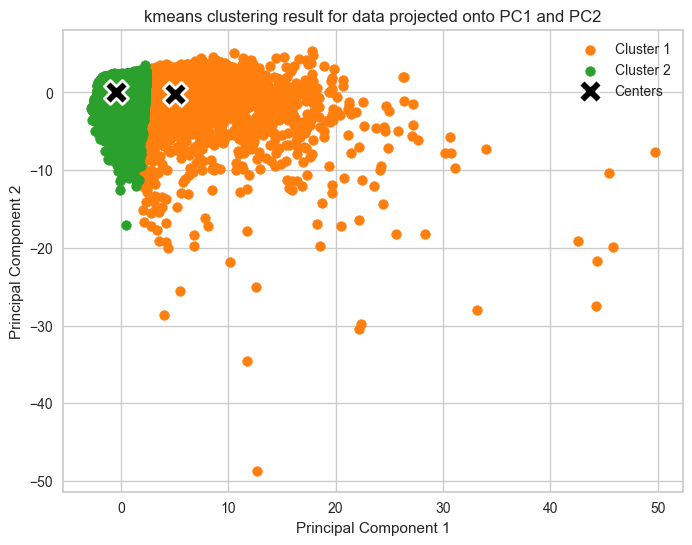

In [105]:
plot_with_pca(df_pca, kmeans_clusters, 'kmeans', kmeans.cluster_centers_, False)

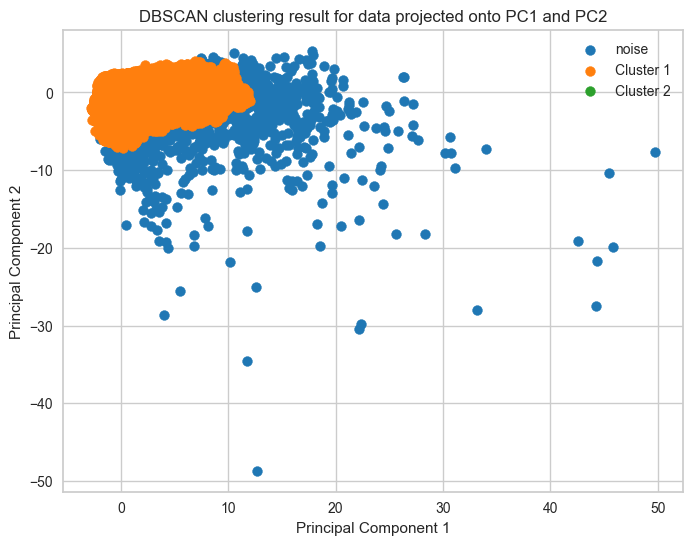

In [106]:
plot_with_pca(df_pca, dbscan_clusters, 'DBSCAN', False)

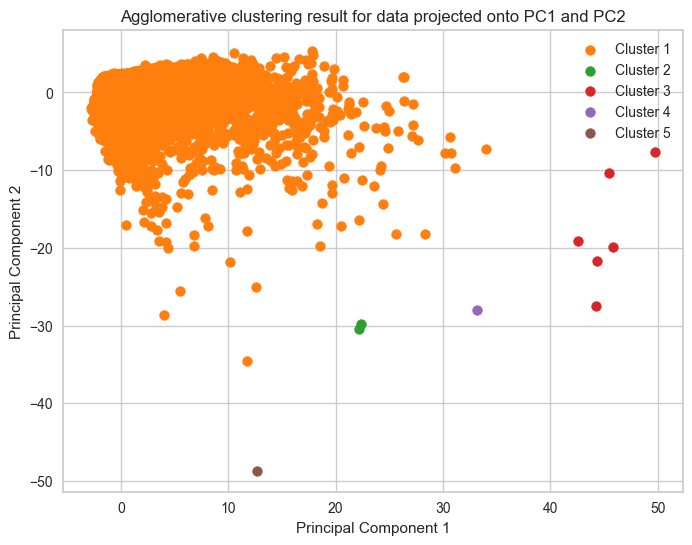

In [107]:
plot_with_pca(df_pca, agg_clusters, 'Agglomerative', False)

to choose the best clustering algorithm we compare evaluation metrics, visualization and business usefulness. by comparing evaluation metrics we can see that Agglomerative Clustering is the best because it has the highest Silhouette score and lowest Davies-Bouldin score. Even though its WCSS is higher (expected for non-centroid algorithms), the other two metrics — which better reflect cluster quality and separation — strongly favor Agglomerative Clustering. But in visualization we can see that almost all data points are assigned to a single cluster (Cluster 1, in orange), while the rest are split into a few tiny, isolated clusters. This means that the model is detecting a dense core with a few outliers or very distinct small groups and the evaluation metrics are artificially inflated — especially silhouette score — because those few small clusters are well-separated from the main mass. In customer segmentation, we want multiple meaningful groups, clusters that can be interpreted and acted on with reasonable balance in size. This makes Agglomerative clustering unusable for segmentation and other algorithms a better choice.

since the projected dataset does not show well seperated clusters, it is almost impossible to interpret clusters based on visualization using PCA.

In [108]:
df_labels = df.loc[df_train.index]

df_labels['kmeans_labels'] = kmeans_clusters
df_labels['DBSCAN_labels'] = dbscan_clusters
df_labels['agg_labels'] = agg_clusters

gp_kmeans = df_labels.groupby('kmeans_labels')
gp_db = df_labels.groupby('DBSCAN_labels')
gp_agg = df_labels.groupby('agg_labels')

now we compare customers in each cluster for kmeans

In [109]:
for name, group in gp_kmeans:
    print(f"Cluster {name + 1}:")
    print(group.describe())
    print("\n")

Cluster 1:
       order_id_count  review_score_mean  review_score_std  \
count     7567.000000        7567.000000       7567.000000   
mean         1.532179           3.850733          0.004612   
std          1.770089           1.509887          0.093559   
min          1.000000           1.000000          0.000000   
25%          1.000000           3.000000          0.000000   
50%          1.000000           5.000000          0.000000   
75%          1.000000           5.000000          0.000000   
max         63.000000           5.000000          2.828427   

       payment_sequential_mean  payment_installments_mean  payment_value_sum  \
count              7567.000000                7567.000000        7567.000000   
mean                  1.064358                   5.608815         894.776664   
std                   0.453590                   3.755485        1504.628513   
min                   1.000000                   1.000000          40.850000   
25%                   1.000000

DBSCAN

In [110]:
for name, group in gp_db:
    print(f"Cluster {name + 1}:")
    print(group.describe())
    print("\n")

Cluster 0:
       order_id_count  review_score_mean  review_score_std  \
count      761.000000         761.000000        761.000000   
mean         3.897503           3.752300          0.013345   
std          4.678057           1.575327          0.138040   
min          1.000000           1.000000          0.000000   
25%          1.000000           3.000000          0.000000   
50%          2.000000           4.500000          0.000000   
75%          6.000000           5.000000          0.000000   
max         63.000000           5.000000          2.190890   

       payment_sequential_mean  payment_installments_mean  payment_value_sum  \
count               761.000000                 761.000000         761.000000   
mean                  1.703022                   4.918099        2713.463193   
std                   1.446813                   4.116154        3919.603194   
min                   1.000000                   1.000000          17.380000   
25%                   1.000000

Agglomerative clustering: as we expected, the clusters are meaningless and provide no business insight.

In [111]:
for name, group in gp_agg:
    print(f"Cluster {name + 1}:")
    print(group.describe())
    print("\n")

Cluster 1:
       order_id_count  review_score_mean  review_score_std  \
count    88113.000000       88113.000000      88113.000000   
mean         1.192628           4.106290          0.002743   
std          0.699081           1.329898          0.068795   
min          1.000000           1.000000          0.000000   
25%          1.000000           4.000000          0.000000   
50%          1.000000           5.000000          0.000000   
75%          1.000000           5.000000          0.000000   
max         38.000000           5.000000          2.828427   

       payment_sequential_mean  payment_installments_mean  payment_value_sum  \
count             88113.000000               88113.000000       88113.000000   
mean                  1.022806                   2.910936         203.593764   
std                   0.179529                   2.697863         460.294534   
min                   1.000000                   0.000000           9.590000   
25%                   1.000000

to improve our business insights we fit another model: kmeans with k=4 on df_pca, this number was chosen based on elbow method.

In [57]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_clusters = kmeans.fit_predict(df_pca)
results(df_pca, kmeans_clusters)

WCSS: 199056.2901361668
Silhouette Score: 0.4086634155441971
Davies Bouldin Score: 0.825113813430322


In [58]:
df_labels = df.loc[df_train.index]
df_labels['kmeans_labels'] = kmeans_clusters
gp_kmeans = df_labels.groupby('kmeans_labels')

for name, group in gp_kmeans:
    print(f"Cluster {name + 1}:")
    print(group.describe())
    print("\n")

Cluster 1:
       order_id_count  review_score_mean  review_score_std  \
count    11728.000000       11728.000000      11728.000000   
mean         1.302780           3.922578          0.004959   
std          0.791241           1.460713          0.097498   
min          1.000000           1.000000          0.000000   
25%          1.000000           3.000000          0.000000   
50%          1.000000           5.000000          0.000000   
75%          1.000000           5.000000          0.000000   
max         12.000000           5.000000          2.828427   

       payment_sequential_mean  payment_installments_mean  payment_value_sum  \
count             11728.000000               11728.000000       11728.000000   
mean                  1.020421                   5.191984         479.239267   
std                   0.113044                   3.550665         460.360445   
min                   1.000000                   1.000000          61.800000   
25%                   1.000000

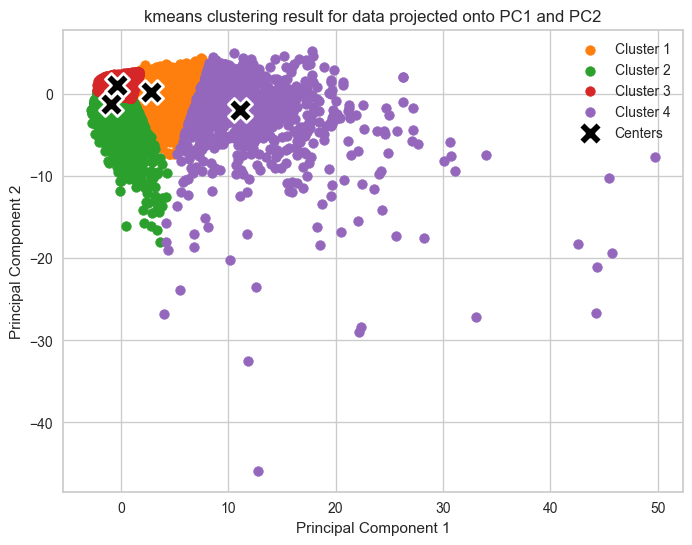

In [59]:
plot_with_pca(df_pca, kmeans_clusters, 'kmeans', kmeans.cluster_centers_, False)

## Cluster Profiling & Business Insight

### kmeans with k=2:

cluster 1 (high spending minority): consists of 7567 customers with an average of 1.5321 orders, 3.8507 review score, 5.6088 payment installments, 894.7766 payment value sum, 597.0090 payment value mean, 7.8402 payment value std, 1056.249 product description length, 2.4442 product photos.


cluster 2 (lower spending majority): consists of 80556 customers with an average of 1.1622 orders, 4.1302 review score, 2.6575 payment installments, 140.3121 payment value sum, 116.351 payment value mean, 0.8714 payment value std, 769.028 product description length, 2.2322 product photos.

recommendations: To retain and grow cluster 1, the business should offer loyalty rewards, personalized product recommendations, and flexible installment plans that cater to their spending habits. Additionally, highlighting premium offerings with rich content and photos can further encourage their purchasing behavior. For cluster 2, the business should focus on scaling sales volume through promotions, while offering short-term installment options to support affordability. Optimizing product listings to be clear but concise, and targeting them with lower-cost products can encourage them to buy more.

### DBSCAN:

Cluster 1 (premium gadget lovers): Consists of 761 customers with an average of 3.8975 orders, 3.7523 review score, 4.9181 payment installments, 2713.4632 payment value sum, 1250.2662 payment value mean, 47.9510 payment value std, 1223.4234 product description length, and 2.3821 product photos.

Cluster 2 (lower spending majority): Consists of 87,362 customers with an average of 1.1705 orders, 4.1093 review score, 2.8934 payment installments, 183.2469 payment value sum, 148.1072 payment value mean, 1.0650 payment value std, 790.1061 product description length, and 2.2494 product photos.

recommendations: the underlying reasons for this clustering is the same with the previous model. so same recommendations apply. however we need to be careful with cluster 1 since these customers are more concered with their products (lower review scores). we should only offer them products with high quality.

### kmeans with k=4:

Cluster 1 (Mid-High Value Customers): Consists of 11,728 customers with an average of 1.3028 orders, 3.9226 review score, 5.1920 payment installments, 479.2393 payment value sum, 360.8992 payment value mean, 3.0658 payment value std, 953.7602 product description length, 2.4070 product photos.

Cluster 2 (Satisfied Budget Shoppers): Consists of 36,541 customers with an average of 1.2469 orders, 4.1648 review score, 2.1121 payment installments, 130.2057 payment value sum, 99.2602 payment value mean, 1.3973 payment value std, 741.9772 product description length, 2.1594 product photos.

Cluster 3 (Cautious Casual Buyers): Consists of 38572 customers with an average of 1.0812 orders, 4.1163 review score, 2.8575 payment installments, 124.2534 payment value sum, 112.4300 payment value mean, 0.2600 payment value std, 772.1579 product description length, and 2.2725 product photos.

Cluster 4 (High-Value Power Buyers): Consists of 1282 customers with an average of 2.0905 orders, 3.8128 review score, 6.4202 payment installments, 2264.1932 payment value sum, 11321.4142 payment value mean, 25.3386 std, 1451.048 product description length, and 2.7544 product photos.

recommendations: Cluster 4 is a small but extremely valuable segment. The business should focus on retention through VIP programs, early access to products, premium support, and exclusive offers. Since their reviews are slightly lower, improving the post-purchase experience—like faster delivery or improved service follow-ups—could boost satisfaction. Cluster 1 shows a moderate number of orders and high average spend, with a good engagement level with product content (longer descriptions and more photos). Although their review score is slightly lower than other clusters, their spending potential is promising. The business should invest in enhanced personalization, targeted upselling, and informative product pages to nurture them further. Improving customer service and delivery tracking may help improve satisfaction (reflected in review scores). Cluster 2 customers are numerous, spend less, but leave high review scores, indicating strong satisfaction with smaller purchases. The focus here should be on volume-driven strategies: optimize for quick, low-cost transactions through simplified product listings, deals on essentials, and one-click purchases. This cluster is ideal for subscription models, flash sales, or automated reorder suggestions. Cluster 3 shows the lowest average number of orders and slightly less spending, with relatively low payment variation (low std), meaning their purchases are very consistent. Despite this, their review scores are high. They are potentially occasional but reliable buyers. The business should engage them with seasonal promotions, gentle reactivation campaigns, and reminders. Offering personalized discounts or highlighting products similar to their past purchases could encourage repeat buying.

## Model Enhancement through Feature Engineering

here we test kmeans on a dataset without categorical variables.

In [86]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_clusters = kmeans.fit_predict(df_train.iloc[:,:-13])
results(df_train.iloc[:,:-13], kmeans_clusters)

WCSS: 15317861574175.79
Silhouette Score: 0.7180976397139223
Davies Bouldin Score: 0.38910974873129517


the results are improved, this suggests trying other encoding or scaling methods. next we add interaction terms.

In [ ]:
poly = PolynomialFeatures(interaction_only=True)
poly_df = poly.fit_transform(df_train.iloc[:,:-13])

this also improves our results.

In [88]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_clusters = kmeans.fit_predict(poly_df)
results(poly_df, kmeans_clusters)

WCSS: 1.2764216474944537e+21
Silhouette Score: 0.8626148881013763
Davies Bouldin Score: 0.5006981007011224
